In [1]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyfix import io, classify
from sklearn import svm, ensemble, neighbors, tree, neural_network as nn, metrics

# Download example data

In [2]:
datadir = '/Users/seanf/scratch/testing-pyfix/example_data'

# Train (group)

Train FIX on a group of labelled subjects.

Generate a table of files.  The table must minimally have a column of `feature` filenames and a column of `label` filenames.  Other columns are allowed and can be used for grouping data.  For example, here I add a column of `subids` that will be used for leave-one-subject-out training.

In [3]:
# from pyfix import legacy, io, classify

features = glob.glob(f'{datadir}/HCP25_hp2000/*/MNINonLinear/Results/rfMRI_REST*/rfMRI_REST*_hp2000.ica/fix/features.pyfix_features')
labels = glob.glob(f'{datadir}/HCP25_hp2000/*/MNINonLinear/Results/rfMRI_REST*/rfMRI_REST*_hp2000.ica/hand_labels_noise.txt')
subid = [f.split('/')[7] for f in labels]

file_table = pd.DataFrame({
    'subid': subid,
    'features': features,
    'labels': labels,
})

file_table.head(10)


subid                                           features  \
0  792564  /Users/seanf/scratch/testing-pyfix/example_dat...   
1  792564  /Users/seanf/scratch/testing-pyfix/example_dat...   
2  792564  /Users/seanf/scratch/testing-pyfix/example_dat...   
3  792564  /Users/seanf/scratch/testing-pyfix/example_dat...   
4  856766  /Users/seanf/scratch/testing-pyfix/example_dat...   
5  856766  /Users/seanf/scratch/testing-pyfix/example_dat...   
6  856766  /Users/seanf/scratch/testing-pyfix/example_dat...   
7  856766  /Users/seanf/scratch/testing-pyfix/example_dat...   
8  499566  /Users/seanf/scratch/testing-pyfix/example_dat...   
9  499566  /Users/seanf/scratch/testing-pyfix/example_dat...   

                                              labels  
0  /Users/seanf/scratch/testing-pyfix/example_dat...  
1  /Users/seanf/scratch/testing-pyfix/example_dat...  
2  /Users/seanf/scratch/testing-pyfix/example_dat...  
3  /Users/seanf/scratch/testing-pyfix/example_dat...  
4  /Users/seanf/scratch/testing-pyfix/example_dat...  
5  /Users/seanf/scratch/testing-pyfix/example_dat...  
6  /Users/seanf/scratch/testing-pyfix/example_dat...  
7  /Users/seanf/scratch/testing-pyfix/example_dat...  
8  /Users/seanf/scratch/testing-pyfix/example_dat...  
9  /Users/seanf/scratch/testing-pyfix/example_dat...

Optionally save/load the `file_table` for reuse:

In [4]:
# save
io.save_file_table(f'{datadir}/HCP25_hp2000/hcp', file_table)

# load
io.read_file_table(f'{datadir}/HCP25_hp2000/hcp.file_table');

File table already exists: /Users/seanf/scratch/testing-pyfix/example_data/HCP25_hp2000/hcp.file_table


Generate a `feature_table` that collates all the features from the files specified in the `file_table`.  Note, that we specify `group_by='subid'` which will add a `group` column to the table based on the `subid`.  This will be used for leave-one-subject-out training.

In [5]:
training_data = classify.collate_features(file_table, legacy_features=False, group_by='subid')
training_data.head()

arfull:0  arfull:1  arfull:2  arfull:3  arfull:4  arvswgn:0  arvswgn:1  \
0  0.020465 -0.989706  0.019260 -1.229937  0.242730  -0.000774   0.020092   
1  0.006556 -0.996714  0.006555 -0.986911 -0.009836  -0.000074   0.006595   
2  0.033442 -0.983123  0.033368 -1.029407  0.047078  -0.000963   0.033760   
3  0.033725 -0.982979  0.033511 -1.061286  0.079663  -0.002705   0.033484   
4  0.028581 -0.985594  0.028456 -1.050688  0.066046  -0.001393   0.028598   

   clusterdist:0  clusterdist:1  clusterdist:2  ...  tsjump:2   tsjump:3  \
0          164.0     102.146341        15741.0  ...  0.020506  12.765491   
1          201.0      53.253731         8428.0  ...  0.005588   7.845732   
2          255.0      39.184314         7687.0  ...  0.032089  12.410799   
3          117.0     165.529915        18506.0  ...  0.033392  11.661642   
4          168.0      69.261905        10388.0  ...  0.025580   8.785997   

   tsjump:4  tsjump:5  zstattofuncratio:0  zstattofuncratio:1  \
0  0.010682  0.989747         6178.921172         4288.312109   
1  0.006565  0.997205         7134.435879         5338.732422   
2  0.010386  0.983942         7687.846562         4976.416309   
3  0.009759  0.983299         4069.844775         2779.257910   
4  0.007352  0.987191         3419.136094         2421.804102   

   zstattofuncratio:2  zstattofuncratio:3   group  label  
0            0.000157            0.000060  792564  False  
1            0.000136            0.000062  792564  False  
2            0.000152            0.000065  792564  False  
3            0.000108            0.000043  792564  False  
4            0.000074            0.000030  792564  False  

[5 rows x 188 columns]

Create a classifier `RandomForest` in this example) and train with leave-out-out evaluation.  Any classifier from [scikit-learn](https://scikit-learn.org/stable/) that generates a probablistic output can be used.

> `n_jobs=-2` will use all the CPUs except 1 for training.  Set to `-1` to use ALL CPUs, or set to a positive integer to speficy the number of CPUs.

In [6]:
clf = ensemble.RandomForestClassifier(n_estimators=50)
# clf = nn.MLPClassifier(solver='lbfgs', early_stopping=True)
# clf = ensemble.GradientBoostingClassifier()
# clf = svm.SVC(probability=True, C=1, gamma='scale', class_weight="balanced")

clf, loo_result = classify.train(training_data, clf, loo=True, n_jobs=-2)

Save trained model.

In [7]:
io.save_model(f'{datadir}/HCP25_hp2000/hcp', clf)

! ls {datadir}/HCP25_hp2000/hcp.pyfix_model

Model file already exists: /Users/seanf/scratch/testing-pyfix/example_data/HCP25_hp2000/hcp.pyfix_model


/Users/seanf/scratch/testing-pyfix/example_data/HCP25_hp2000/hcp.pyfix_model


Report LOO classification results as per `legacy FIX`.

In [8]:
from pyfix import legacy
print(legacy.report_loo(loo_result.actual, loo_result.predicted_pb, loo_result.idx))

                TPR                                                                             TNR                                                                       (3*TPR+TNR)/4                                                                      
Threshold      1.0       2.0       5.0       10.0      20.0      30.0      40.0      50.0      1.0       2.0       5.0       10.0      20.0      30.0      40.0      50.0          1.0       2.0       5.0       10.0      20.0      30.0      40.0      50.0
Fold                                                                                                                                                                                                                                                         
0          1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  0.989130  0.881057  0.959251  0.979075  0.992291  0.993392  0.993392  0.995595  0.995595      0.970264  0.989813  0.994769  0.998073  0.998348  0.998348  0.9

Create html LOO report with feature importance.

In [9]:
# group related features

feat_groups = np.unique([f.split(':')[0] for f in loo_result.feature_labels])
feat_groups = {featname: np.where(pd.Series(loo_result.feature_labels).str.contains(featname))[0].tolist() for featname in feat_groups}

# create report and save to training-report.html

classify.report_loo(loo_result, 'training-report.html', threshold=np.arange(0.05, 0.55, 0.05), feat_groups=feat_groups)

/Users/seanf/miniconda3/envs/fslpython604/lib/python3.7/site-packages/seaborn/axisgrid.py:643: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/Users/seanf/miniconda3/envs/fslpython604/lib/python3.7/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/seanf/miniconda3/envs/fslpython604/lib/python3.7/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


# Classify (single subject)

Apply a trained model to classify the independent components from a single subject.

In [10]:
features0 = io.read_features(file_table.loc[0, 'features'])
    
y_pred_pb = classify.classify(features0, clf)[1]
y_pred = legacy.prob_threshold(y_pred_pb, threshold=0.2)

print(y_pred)

[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False  True False False False False False  True False
 False False False False False False  True False False False False  True
 False False  True False False  True False False  True False False  True
  True False  True  True False False False False False  True False  True
 False False False False False False False False  True False False False
 False False False False False False False False False False False False
 False  True  True False False False False False False False False False
  True False False False False False  True False  True False False  True
 False False False False False False False False False False  True False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False Fa

Load original hand classifications (`hand_labels_noise.txt`) for the same subject.

In [11]:
y = np.ones(y_pred.shape).astype(bool)
y[legacy.read_labels(file_table.loc[0, 'labels'])-1] = False

print(y)

[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False  True False False False False False  True False
 False False False False False False  True False False False False  True
 False False  True False False  True False False  True False False  True
  True False  True  True False False False False False  True False  True
 False False False False False False False False  True False False False
 False False False False False False False False False False False False
 False  True  True False False False False False False False False False
  True False False False False False  True False  True False False  True
 False False False False False False False False False False  True False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False Fa

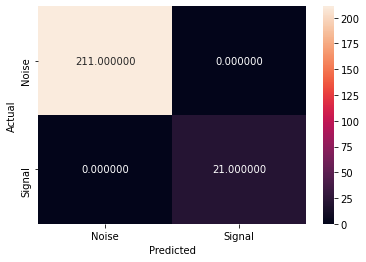

In [12]:
cm = metrics.confusion_matrix(y, y_pred)

sns.heatmap(cm, annot=True, fmt='f')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.gca().set_xticklabels(['Noise', 'Signal'])
plt.gca().set_yticklabels(['Noise', 'Signal']);

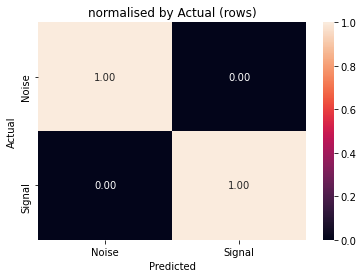

In [13]:
cm_norm = metrics.confusion_matrix(y, y_pred, normalize='true')

sns.heatmap(cm_norm, annot=True, fmt='0.2f')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('normalised by Actual (rows)')

plt.gca().set_xticklabels(['Noise', 'Signal'])
plt.gca().set_yticklabels(['Noise', 'Signal']);